<a href="https://colab.research.google.com/github/Nicko-o/0_PyTorch-Deep-Learning/blob/main/01_PyTorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch WorkFlow
Let's explore an example PyTorch end-to-end workflow.

In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build a model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evalluating a model (iniference)",
                      5: "saving a loading a model",
                      6: "putting it all toogether"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build a model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evalluating a model (iniference)',
 5: 'saving a loading a model',
 6: 'putting it all toogether'}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

## 1. Data (preparing and loading)

Data can be almost anyting... in machine learning.

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

Let's create some example by creating a lineaer regression formula. To make. straight line with *known* **parameters**

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (and sometimes validation)

In [5]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## Visualising data with math plot lib

In [6]:
def plot_predictions(train_data=X_train,
                      train_labels=y_train,
                      test_data=X_test,
                      test_labels=y_test,
                      predictions=None):
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14});

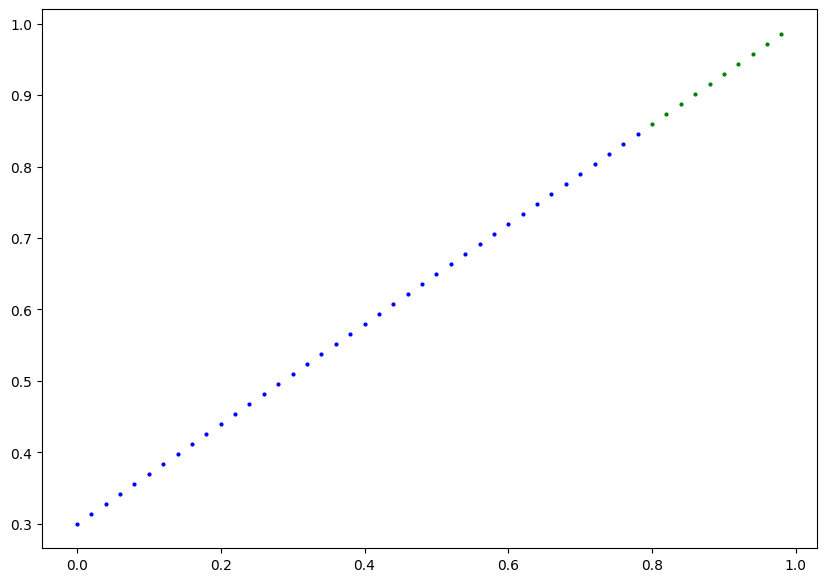

In [7]:
plot_predictions()

## 2. Build model

Our first PyTorch model!


In [8]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherits from the nn module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))

    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, X: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * X + self.bias # This is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs.
* torch.nn.Parameter - what parameters should our model try and learn.
* torch.nn.Module - The base class for all neural network modules.
* torch.optim - this is where the optimizers in PyTorch live, they wil help with gradient descent.
* def forward() - All nn.Module subclasses require you to overwite forward(), this method defines what happens in the forward computation.

### Checking the contents of our PyTorch model

using `.parameters()`

In [9]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check out models predictive power, let's see how well it predicts on `y_test` based on the `X_test`.

When we pass data through our model, it's gonna run through the "forward" method

In [11]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [12]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

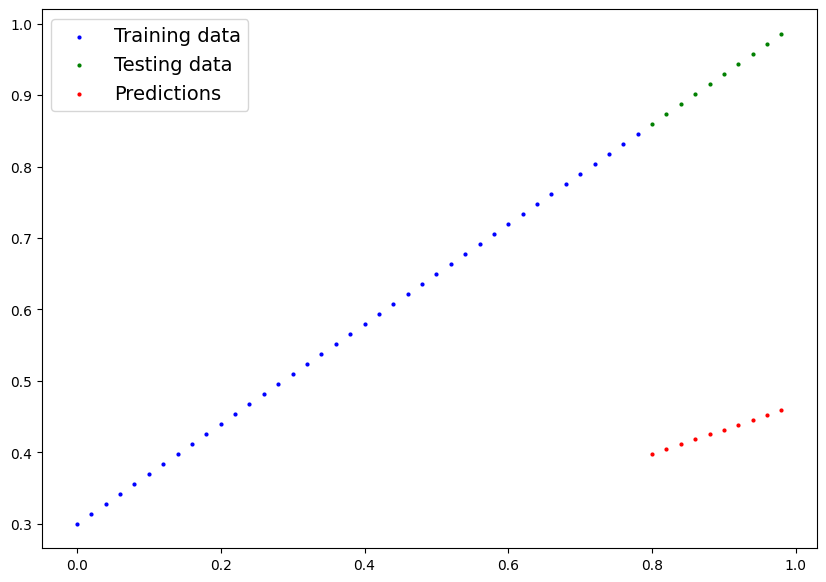

In [13]:
plot_predictions(predictions=y_preds)

## 3. Train model


The whole idea of training is for model to move from unknown parameters to some knows parameters. From poor representation to some better representation.

One way to measure how poor model prediction are is to use a **loss function**.

* Loss function may also be called cost function or criterion.

Things we need to train:

* **Loss function:** A function to measure how wrong your mode's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g weight & bias) to improve the loss function

And specifically for PyTorch we need:
* A training loop
* A testing loop

In [14]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [15]:
# check out our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
# Set up a loss function
# L1Loss = Mean Absolute Error\

# loss_fn = torch.mean(torch.abs(y_preds-y_test))
loss_fn = nn.L1Loss()

# Set up optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr - learning rate = most import hyperparameter you can set

### Building a training loop (and testing loop) in Pytorch

Training loop:
0. Loop through the data.
1. Forward pass (this involves data moving through our model's `forward()` functions to make predictions in data - also called forward propagation.
2. Calculate the loss (compare forward pass prediction to ground truth labels).
3. Optimizer zero grad.
4. Loss backward - move backwards through the network to calculate the gradient of each of the parameters of our model with respect to the loss (**backpropagation**).
5. Optimizer step - use the optimizer to adjust out model's parameters to try and improve the loss (**gradient descent**).

In [18]:
torch.manual_seed(42)

# Am epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 1

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # traing mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  print(f"Loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameteres of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop


  ### Testing
  model_0.eval() # turns off gradient tracking

  # Print out model state_dict()
  print(model_0.state_dict())



Loss: 0.31288138031959534
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Loss: 0.3013603389263153
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
Loss: 0.28983935713768005
OrderedDict([('weights', tensor([0.3484])), ('bias', tensor([0.1588]))])
Loss: 0.2783183455467224
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
Loss: 0.26679736375808716
OrderedDict([('weights', tensor([0.3562])), ('bias', tensor([0.1788]))])
Loss: 0.2552763521671295
OrderedDict([('weights', tensor([0.3601])), ('bias', tensor([0.1888]))])
Loss: 0.24375534057617188
OrderedDict([('weights', tensor([0.3640])), ('bias', tensor([0.1988]))])
Loss: 0.23223432898521423
OrderedDict([('weights', tensor([0.3679])), ('bias', tensor([0.2088]))])
Loss: 0.22071333229541779
OrderedDict([('weights', tensor([0.3718])), ('bias', tensor([0.2188]))])
Loss: 0.20919232070446014
OrderedDict([('weights', tensor([0.3757])), ('bias', tensor([0.2288]))])
Loss: 0.19767

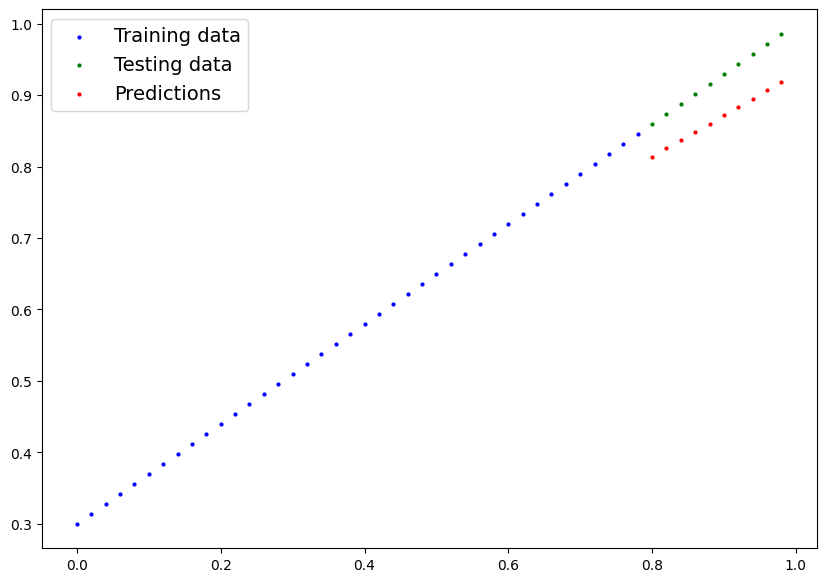

In [19]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
plot_predictions(predictions=y_preds_new)